In [37]:
import numpy as np
import pandas as pd
#import matplotlib.pyplot as plt

all_data = pd.read_csv('sales所在周次节假日.csv')
all_data.rename(columns={'店铺名称':'store','地理位置指数':'position','年份':'years','周次':'weeks of year','是否包含法定节假日':'Isholiday','季节':'season','大类':'item','销量':'sales','均价':'prices','促销':'discount'},inplace=True)
all_data['weeks'] = all_data['weeks of year']
a = all_data
week_5 = a.loc[lambda a : a['years'] == 2015]
week_6 = a.loc[lambda a : a['years'] == 2016]
week_6['weeks'] += 53
a = pd.concat([week_5,week_6])

from sklearn import preprocessing

#map店铺名称
name = a['store']
le = preprocessing.LabelEncoder()
le.fit(name)
list(name)
le.transform(name)
tmp = le.transform(name)
a['store'] = tmp

#map合并大类
category = a['item']
le.fit(category)
list(category)
le.transform(category)
tmp = le.transform(category)
a['item'] = tmp

#map季节
season = a['season']
le.fit(season)
list(season)
le.transform(season)
tmp = le.transform(season)
a['season'] = tmp

a

/home/lin/anaconda3/envs/boost/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()


,store,position,years,weeks of year,Isholiday,season,item,sales,prices,discount,weeks
0,0,7,2015,1,1,0,1,1,499.666700,0.333333,1
1,0,7,2015,1,1,0,2,30,513.066663,0.371160,1
2,0,7,2015,1,1,0,9,2,683.833300,0.325790,1
3,0,7,2015,1,1,0,10,2,799.600000,0.400000,1
4,0,7,2015,1,1,2,6,1,375.600000,0.400000,1
5,0,7,2015,1,1,3,7,2,366.333350,0.333333,1
6,0,7,2015,2,0,0,1,1,799.000000,0.470277,2
7,0,7,2015,2,0,0,2,6,645.833333,0.467205,2
8,0,7,2015,2,0,2,6,1,563.000000,0.599574,2
9,0,7,2015,2,0,3,6,2,354.000000,0.385201,2


In [38]:
df = a
masked_series = (df['years']==2016) & (df['weeks'].isin([53,54,55]))
masked_series2 = (df['years']==2016) & (~(df['weeks'].isin([53,54,55])))
df.loc[(masked_series), 'train_or_test'] = 'test'
df.loc[(masked_series2), 'train_or_test'] = 'no_train'
print('Train shape: {}'.format(df.loc[df['years']==2015,:].shape))
print('Test shape: {}'.format(df.loc[df.train_or_test=='test',:].shape))


Train shape: (8119, 12)
Test shape: (340, 12)


In [39]:
df_n = df.drop(['train_or_test'],axis=1)

#log sales,prices
#df_n['sales'] = np.log1p(df.sales.values)
df_n['prices'] = np.log1p(df.sales.values)
df_n.sample(2)
#df_n = df_n.drop(['prices','discount'],axis=1)

,store,position,years,weeks of year,Isholiday,season,item,sales,prices,discount,weeks
12655,21,7,2015,22,0,2,6,4,1.609438,0.43988,22
16901,28,7,2015,15,0,2,6,21,3.091042,0.43340,15


In [40]:
outlier = df_n[lambda df_n: df_n['sales'] > 200]
#outlier.index
df_n = df_n.drop([2215, 2222, 2341, 2511, 2518, 2984, 5672, 2583, 2730, 2890, 2897,8064])

In [41]:
for i in df_n['store'].drop_duplicates():
    a = df_n[lambda df_n : df_n['store'] == i]
    b = a['weeks'].drop_duplicates().count()
    print (i,b)
    if b != 106:
        s_ = df_n[lambda df_n: df_n['store'] == i]
        index_s = s_.index
        df_n = df_n.drop(index_s)

0 106
2 106
3 106
4 106
5 106
6 106
7 106
8 106
9 106
10 106
11 106
12 106
13 79
14 106
16 106
17 106
18 106
19 106
21 106
22 106
23 106
24 106
25 106
26 92
27 106
28 106
29 106
1 17
15 17
20 29


In [42]:
train = df_n[lambda df_n: df_n['weeks'] < 54]
#train = df_n.sort_values('weeks',ascending='True')
#train = train.drop(['prices','discount'],axis=1)
y_train = train['sales']

In [ ]:
#评价指标：

def mae(y_pred, y_true):
    errors = abs(y_pred - y_true)
    return np.sum(errors) / len(y_true)
def mape(y_pred, y_true):
    # calculate error
    #denom = (abs(y_pred) + abs(y_true)) / 2
    errors = abs((y_pred - y_true) / y_true)
    return 100 *np.sum(errors) / len(y_true)
def smape(y_pred, y_true):
    # calculate error
    denom = (abs(y_pred) + abs(y_true)) / 2
    errors = abs(y_pred - y_true) / denom
    return 100 *np.sum(errors) / len(y_true)

In [43]:
#train = df_n[lambda df_n: df_n['years']==2015]
#t1 = df_n[lambda df_n: df_n['weeks']==54]
#t2 = df_n[lambda df_n: df_n['weeks']==55]
#t3 = df_n[lambda df_n: df_n['weeks']==56]
#test = pd.concat([t1,t2,t3])

#y_train = train['sales']
#y_test = test['sales']
#X_train = train.drop('sales', axis=1)
#X_test = test.drop('sales', axis=1)

In [44]:
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn import svm
from sklearn.neural_network import MLPRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error,r2_score
import xgboost as xgb
import lightgbm as lgb

In [45]:
#Validation function
n_folds = 3

def rmsle_cv(model):
    kf = KFold(n_folds).get_n_splits(train.values)
    rmse= np.sqrt(-cross_val_score(model, train.values, y_train, scoring="neg_mean_squared_error", cv = kf))
    return(rmse)

In [46]:
lasso = make_pipeline(RobustScaler(), Lasso(alpha =0.0005, random_state=1))
ENet = make_pipeline(RobustScaler(), ElasticNet(alpha=0.0005, l1_ratio=.9, random_state=3))
KRR = KernelRidge(alpha=0.6, kernel='polynomial', degree=2, coef0=2.5)
model_svm = svm.SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1,
                    gamma='auto', kernel='rbf', max_iter=-1, shrinking=True,
                    tol=0.001, verbose=False)

model_regr = RandomForestRegressor(max_depth=2, random_state=0,
                                    n_estimators=100)
GBoost = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   loss='huber', random_state =5)
# model_xgb = xgb.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, 
#                              learning_rate=0.05, max_depth=3, 
#                              min_child_weight=1.7817, n_estimators=2200,
#                              reg_alpha=0.4640, reg_lambda=0.8571,
#                              subsample=0.5213, silent=1,
#                              random_state =7, nthread = -1)
# model_lgb = lgb.LGBMRegressor(objective='regression',num_leaves=5,
#                               learning_rate=0.05, n_estimators=720,
#                               max_bin = 55, bagging_fraction = 0.8,
#                               bagging_freq = 5, feature_fraction = 0.2319,
#                               feature_fraction_seed=9, bagging_seed=9,
#                               min_data_in_leaf =6, min_sum_hessian_in_leaf = 11)
model_xgb = xgb.XGBRegressor(njob=-1)
model_lgb = lgb.LGBMRegressor(njob=-1)
model_mlp = MLPRegressor(activation='identity')


In [47]:
# score = rmsle_cv(lasso)
# print("\nLasso score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))
# score = rmsle_cv(ENet)
# print("ElasticNet score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))
# #score = rmsle_cv(KRR)
# #print("Kernel Ridge score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))
# #score = rmsle_cv(GBoost)
# #print("Gradient Boosting score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))
# score = rmsle_cv(model_xgb)
# print("Xgboost score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))
# score = rmsle_cv(model_lgb)
# print("LGBM score: {:.4f} ({:.4f})\n" .format(score.mean(), score.std()))

In [48]:
df_test = df_n[lambda df_n: df_n['weeks'] > 53]
df_test_1 = df_test[lambda df_n: df_n['weeks'] <67]
df_test_2_ = df_test[lambda df_n: df_n['weeks'] <79]
df_test_2 = df_test_2_[lambda df_n: df_n['weeks'] >67]
df_test_3_ = df_test[lambda df_n: df_n['weeks'] <92]
df_test_3 = df_test_3_[lambda df_n: df_n['weeks'] >79]
df_test_4 = df_test[lambda df_n: df_n['weeks'] >92]

In [49]:
df_train = df_n[lambda df_n: df_n['weeks'] < 53]
df_train_1 = df_train[lambda df_n: df_n['weeks'] <14]
df_train_2_ = df_train[lambda df_n: df_n['weeks'] <27]
df_train_2 = df_train_2_[lambda df_n: df_n['weeks'] >14]
df_train_3_ = df_train[lambda df_n: df_n['weeks'] <40]
df_train_3 = df_train_3_[lambda df_n: df_n['weeks'] >27]
df_train_4 = df_train[lambda df_n: df_n['weeks'] >40]

In [50]:
df_test_0_x = df_test.drop(['sales'],axis=1)
df_test_0_y = df_test['sales']
df_test_1_x = df_test_1.drop(['sales'],axis=1)
df_test_1_y = df_test_1['sales']
df_test_2_x = df_test_2.drop(['sales'],axis=1)
df_test_2_y = df_test_2['sales']
df_test_3_x = df_test_3.drop(['sales'],axis=1)
df_test_3_y = df_test_3['sales']
df_test_4_x = df_test_4.drop(['sales'],axis=1)
df_test_4_y = df_test_4['sales']

df_train_0_x = df_train.drop(['sales'],axis=1)
df_train_0_y = df_train['sales']
df_train_1_x = df_train_1.drop(['sales'],axis=1)
df_train_1_y = df_train_1['sales']
df_train_2_x = df_train_2.drop(['sales'],axis=1)
df_train_2_y = df_train_2['sales']
df_train_3_x = df_train_3.drop(['sales'],axis=1)
df_train_3_y = df_train_3['sales']
df_train_4_x = df_train_4.drop(['sales'],axis=1)
df_train_4_y = df_train_4['sales']

In [51]:
import matplotlib.pylab as plt

def rmse_test(model):
    model = model.fit(df_train_0_x,df_train_0_y)
    y_pred_1 = model.predict(df_test_1_x)
    print('The rmse of prediction is:', mean_squared_error(df_test_1_y, y_pred_1) ** 0.5)
    print('The R^2 of prediction is:', r2_score(df_test_1_y, y_pred_1))
    


In [53]:
rmse_test(lasso)
rmse_test(model_svm)
rmse_test(model_regr)
rmse_test(GBoost)
rmse_test(model_xgb)
rmse_test(model_xgb)
rmse_test(model_mlp)

The rmse of prediction is: 8.482563371579579
The R^2 of prediction is: 0.6349788533551317
The rmse of prediction is: 14.459422407563828
The R^2 of prediction is: -0.06063435313316923
The rmse of prediction is: 4.393859533917694
The R^2 of prediction is: 0.902060893588389
The rmse of prediction is: 1.920630506199611
The R^2 of prediction is: 0.9812866541252079
The rmse of prediction is: 0.18916243726890417
The R^2 of prediction is: 0.9998184761887261
The rmse of prediction is: 0.18916243726890417
The R^2 of prediction is: 0.9998184761887261
The rmse of prediction is: 10.562294220077478
The R^2 of prediction is: 0.4340470589983422


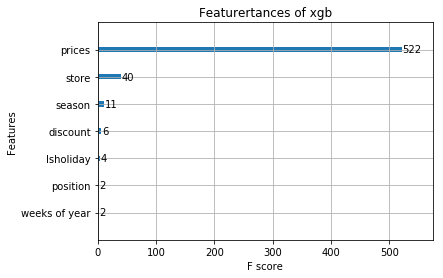

In [18]:
import matplotlib.pylab as plt

#plt.figure(figsize=(12,6))
xgb.plot_importance(rmse_test.model_get(model_xgb), max_num_features=30)
plt.title("Featurertances of xgb")
plt.show()

In [19]:
rmse_test.rmse_compute(model_lgb)
rmse_test.model_get(model_lgb)

The rmse of prediction is: 1.8800172139524893
The R^2 of prediction is: 0.9820697043390899


LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       importance_type='split', learning_rate=0.1, max_depth=-1,
       min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
       n_estimators=100, n_jobs=-1, njob=-1, num_leaves=31, objective=None,
       random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
       subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

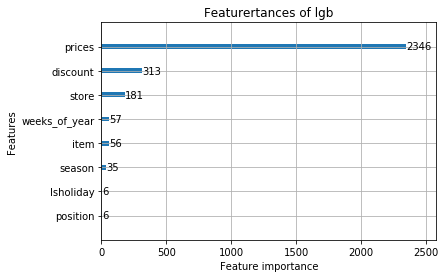

In [20]:


#plt.figure(figsize=(12,6))
lgb.plot_importance(rmse_test.model_get(model_lgb), max_num_features=30)
plt.title("Featurertances of lgb")
plt.show()

# 第一次迭代

In [21]:
#去头，尾变
model_xgb.fit(df_train_0_x,df_train_0_y)
y_pred_1 = pd.DataFrame(model_xgb.predict(df_test_1_x))

In [22]:
train_ite_1_x = pd.concat([df_train_2_x,df_train_3_x,df_train_4_x,df_test_1_x])
train_ite_1_y = pd.concat([df_train_2_y,df_train_3_y,df_train_4_y,y_pred_1])

In [23]:
def rmse_test(model):
    model = model.fit(train_ite_1_x,train_ite_1_y)
    y_pred_2 = model.predict(df_test_2_x)
    print('The rmse of prediction is:', mean_squared_error(df_test_2_y, y_pred_2) ** 0.5)
    print('The R^2 of prediction is:', r2_score(df_test_2_y, y_pred_2))

rmse_test(lasso)
rmse_test(model_svm)
rmse_test(model_regr)
rmse_test(GBoost)

rmse_test(model_xgb)
rmse_test(model_lgb)
rmse_test(model_mlp)


The rmse of prediction is: 5.3837882253466445
The R^2 of prediction is: 0.7036870153792605


/home/lin/anaconda3/envs/boost/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


The rmse of prediction is: 10.34594593888737
The R^2 of prediction is: -0.09424647390558882


/home/lin/anaconda3/envs/boost/lib/python3.7/site-packages/ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


The rmse of prediction is: 3.218028594581416
The R^2 of prediction is: 0.894134477832525


/home/lin/anaconda3/envs/boost/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


The rmse of prediction is: 0.6453963391974499
The R^2 of prediction is: 0.9957417834681519
The rmse of prediction is: 0.0655325258682639
The R^2 of prediction is: 0.999956097569753
The rmse of prediction is: 0.1761650898128709
The R^2 of prediction is: 0.9996827406387777


/home/lin/anaconda3/envs/boost/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:1316: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


The rmse of prediction is: 5.735122561450081
The R^2 of prediction is: 0.6637516568557649


In [24]:
class rmse_test:
    def __init__(self,model):
        self.model=model
    def rmse_compute(model):
        model = model.fit(train_ite_1_x,train_ite_1_y)
        y_pred_2 = model.predict(df_test_2_x)
        print('The rmse of prediction is:', mean_squared_error(df_test_2_y, y_pred_2) ** 0.5)
        print('The R^2 of prediction is:', r2_score(df_test_2_y, y_pred_2))
    def model_get(model):
        model = model.fit(df_train_0_x,df_train_0_y)
        return model




rmse_test(lasso)
rmse_test(model_svm)
rmse_test(model_regr)
rmse_test(GBoost)

rmse_test.rmse_compute(model_xgb)
rmse_test.rmse_compute(model_lgb)
rmse_test(model_mlp)

The rmse of prediction is: 0.0655325258682639
The R^2 of prediction is: 0.999956097569753
The rmse of prediction is: 0.1761650898128709
The R^2 of prediction is: 0.9996827406387777


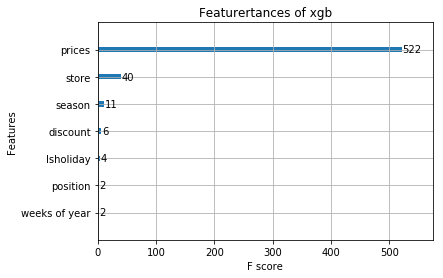

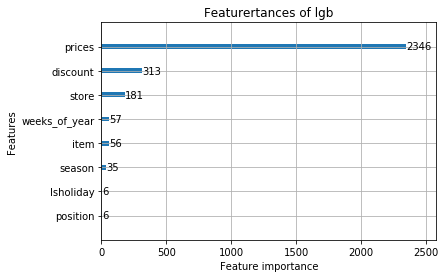

In [25]:
xgb.plot_importance(rmse_test.model_get(model_xgb), max_num_features=30)
plt.title("Featurertances of xgb")
plt.show()

lgb.plot_importance(rmse_test.model_get(model_lgb), max_num_features=30)
plt.title("Featurertances of lgb")
plt.show()

In [26]:
#去头，尾不变
train_ite_1_x = pd.concat([df_train_2_x,df_train_3_x,df_train_4_x,df_test_1_x])
train_ite_1_y = pd.concat([df_train_2_y,df_train_3_y,df_train_4_y,df_test_1_y])

def rmse_test(model):
    model = model.fit(train_ite_1_x,train_ite_1_y)
    y_pred_2 = model.predict(df_test_2_x)
    print('The rmse of prediction is:', mean_squared_error(df_test_2_y, y_pred_2) ** 0.5)
    print('The R^2 of prediction is:', r2_score(df_test_2_y, y_pred_2))

rmse_test(lasso)
rmse_test(model_svm)
rmse_test(model_regr)
rmse_test(GBoost)
rmse_test(model_xgb)
rmse_test(model_lgb)
rmse_test(model_mlp)


The rmse of prediction is: 5.3865118621674934
The R^2 of prediction is: 0.7033871324481231
The rmse of prediction is: 10.346020326073896
The R^2 of prediction is: -0.09426220919159678
The rmse of prediction is: 3.217366495234879
The R^2 of prediction is: 0.8941780363530472
The rmse of prediction is: 0.7748473510246376
The R^2 of prediction is: 0.9938622802910116
The rmse of prediction is: 0.06488890485357622
The R^2 of prediction is: 0.999956955701407
The rmse of prediction is: 0.17748583695611828
The R^2 of prediction is: 0.9996779656843959
The rmse of prediction is: 5.831582456251329
The R^2 of prediction is: 0.6523457140289228


In [27]:
#不去头，尾变
train_ite_1_x = pd.concat([df_train_1_x,df_train_2_x,df_train_3_x,df_train_4_x,df_test_1_x])
train_ite_1_y = pd.concat([df_train_1_y,df_train_2_y,df_train_3_y,df_train_4_y,y_pred_1])

def rmse_test(model):
    model = model.fit(train_ite_1_x,train_ite_1_y)
    y_pred_2 = model.predict(df_test_2_x)
    print('The rmse of prediction is:', mean_squared_error(df_test_2_y, y_pred_2) ** 0.5)
    print('The R^2 of prediction is:', r2_score(df_test_2_y, y_pred_2))

rmse_test(lasso)
rmse_test(model_svm)
rmse_test(model_regr)
rmse_test(GBoost)
rmse_test(model_xgb)
rmse_test(model_lgb)
rmse_test(model_mlp)


The rmse of prediction is: 5.3643816004502725
The R^2 of prediction is: 0.7058193692449086


/home/lin/anaconda3/envs/boost/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


The rmse of prediction is: 10.339005190047255
The R^2 of prediction is: -0.0927787797168349


/home/lin/anaconda3/envs/boost/lib/python3.7/site-packages/ipykernel_launcher.py:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


The rmse of prediction is: 3.2734572035297873
The R^2 of prediction is: 0.8904561296398941


/home/lin/anaconda3/envs/boost/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


The rmse of prediction is: 0.3344907990344275
The R^2 of prediction is: 0.998856218419783
The rmse of prediction is: 0.05244048150481364
The R^2 of prediction is: 0.9999718869420557
The rmse of prediction is: 0.08003449734059483
The R^2 of prediction is: 0.9999345169062156


/home/lin/anaconda3/envs/boost/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:1316: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


The rmse of prediction is: 5.565900140493287
The R^2 of prediction is: 0.6833018205278961


In [28]:
#不去头，尾不变
train_ite_1_x = pd.concat([df_train_1_x,df_train_2_x,df_train_3_x,df_train_4_x,df_test_1_x])
train_ite_1_y = pd.concat([df_train_1_y,df_train_2_y,df_train_3_y,df_train_4_y,df_test_1_y])

def rmse_test(model):
    model = model.fit(train_ite_1_x,train_ite_1_y)
    y_pred_2 = model.predict(df_test_2_x)
    print('The rmse of prediction is:', mean_squared_error(df_test_2_y, y_pred_2) ** 0.5)
    print('The R^2 of prediction is:', r2_score(df_test_2_y, y_pred_2))

rmse_test(lasso)
rmse_test(model_svm)
rmse_test(model_regr)
rmse_test(GBoost)
rmse_test(model_xgb)
rmse_test(model_lgb)
rmse_test(model_mlp)


The rmse of prediction is: 5.3666798286878405
The R^2 of prediction is: 0.7055672473377392
The rmse of prediction is: 10.33905607403344
The R^2 of prediction is: -0.09278953608577756
The rmse of prediction is: 3.266550645262166
The R^2 of prediction is: 0.8909178879244303
The rmse of prediction is: 0.3782386864536073
The R^2 of prediction is: 0.9985374637484745
The rmse of prediction is: 0.05232822619979671
The R^2 of prediction is: 0.9999720071721555
The rmse of prediction is: 0.0780836857874715
The R^2 of prediction is: 0.9999376702540631
The rmse of prediction is: 5.635286180426365
The R^2 of prediction is: 0.6753565101108034


# 第二次迭代

In [29]:
#去头，尾变
model_xgb.fit(train_ite_1_x,train_ite_1_y)
y_pred_2 = pd.DataFrame(model_xgb.predict(df_test_2_x))

train_ite_2_x = pd.concat([df_train_3_x,df_train_4_x,df_test_1_x,df_test_2_x])
train_ite_2_y = pd.concat([df_train_3_y,df_train_4_y,df_test_1_y,y_pred_2])

def rmse_test(model):
    model = model.fit(train_ite_2_x,train_ite_2_y)
    y_pred_3 = model.predict(df_test_3_x)
    print('The rmse of prediction is:', mean_squared_error(df_test_3_y, y_pred_3) ** 0.5)
    print('The R^2 of prediction is:', r2_score(df_test_3_y, y_pred_3))
    
rmse_test(lasso)
rmse_test(model_svm)
rmse_test(model_regr)
rmse_test(GBoost)
rmse_test(model_xgb)
rmse_test(model_lgb)
rmse_test(model_mlp)


The rmse of prediction is: 5.3952954961446435
The R^2 of prediction is: 0.6139690015683514


/home/lin/anaconda3/envs/boost/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


The rmse of prediction is: 8.8121873147064
The R^2 of prediction is: -0.02981484730901296


/home/lin/anaconda3/envs/boost/lib/python3.7/site-packages/ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


The rmse of prediction is: 3.1236654986206323
The R^2 of prediction is: 0.8706040300739829


/home/lin/anaconda3/envs/boost/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


The rmse of prediction is: 0.2721593682684476
The R^2 of prediction is: 0.9990177132516642
The rmse of prediction is: 0.06839615045745763
The R^2 of prediction is: 0.9999379623944952
The rmse of prediction is: 0.21573566660631308
The R^2 of prediction is: 0.999382786224041


/home/lin/anaconda3/envs/boost/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:1316: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


The rmse of prediction is: 6.320871657499846
The R^2 of prediction is: 0.4701588882394159


In [30]:
#去头，尾不变
train_ite_2_x = pd.concat([df_train_3_x,df_train_4_x,df_test_1_x,df_test_2_x])
train_ite_2_y = pd.concat([df_train_3_y,df_train_4_y,df_test_1_y,df_test_2_y])

def rmse_test(model):
    model = model.fit(train_ite_2_x,train_ite_2_y)
    y_pred_3 = model.predict(df_test_3_x)
    print('The rmse of prediction is:', mean_squared_error(df_test_3_y, y_pred_3) ** 0.5)
    print('The R^2 of prediction is:', r2_score(df_test_3_y, y_pred_3))
    
rmse_test(lasso)
rmse_test(model_svm)
rmse_test(model_regr)
rmse_test(GBoost)
rmse_test(model_xgb)
rmse_test(model_lgb)
rmse_test(model_mlp)


The rmse of prediction is: 5.395193448357717
The R^2 of prediction is: 0.6139836043779858
The rmse of prediction is: 8.812237500630975
The R^2 of prediction is: -0.029826577054551606
The rmse of prediction is: 3.0855793092602712
The R^2 of prediction is: 0.8737401886488094
The rmse of prediction is: 0.26144520200042315
The R^2 of prediction is: 0.9990935307815464
The rmse of prediction is: 0.06338502516882535
The R^2 of prediction is: 0.9999467198985593
The rmse of prediction is: 0.21728482942110602
The R^2 of prediction is: 0.9993738901738226
The rmse of prediction is: 5.494311147907138
The R^2 of prediction is: 0.5996699329020974


In [31]:
#不去头，尾变
model_xgb.fit(train_ite_1_x,train_ite_1_y)
y_pred_2 = pd.DataFrame(model_xgb.predict(df_test_2_x))

train_ite_2_x = pd.concat([df_train_1_x,df_train_2_x,df_train_3_x,df_train_4_x,df_test_1_x,df_test_2_x])
train_ite_2_y = pd.concat([df_train_1_y,df_train_2_y,df_train_3_y,df_train_4_y,df_test_1_y,y_pred_2])

def rmse_test(model):
    model = model.fit(train_ite_2_x,train_ite_2_y)
    y_pred_3 = model.predict(df_test_3_x)
    print('The rmse of prediction is:', mean_squared_error(df_test_3_y, y_pred_3) ** 0.5)
    print('The R^2 of prediction is:', r2_score(df_test_3_y, y_pred_3))
    
rmse_test(lasso)
rmse_test(model_svm)
rmse_test(model_regr)
rmse_test(GBoost)
rmse_test(model_xgb)
rmse_test(model_lgb)
rmse_test(model_mlp)


The rmse of prediction is: 5.366871627345219
The R^2 of prediction is: 0.6180257178066968


/home/lin/anaconda3/envs/boost/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


The rmse of prediction is: 8.795995893048985
The R^2 of prediction is: -0.02603398170627136


/home/lin/anaconda3/envs/boost/lib/python3.7/site-packages/ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


The rmse of prediction is: 3.0380815609547036
The R^2 of prediction is: 0.8775974215449698


/home/lin/anaconda3/envs/boost/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


The rmse of prediction is: 0.23737332325287988
The R^2 of prediction is: 0.9992527678853277
The rmse of prediction is: 0.072531960967219
The R^2 of prediction is: 0.9999302329199146
The rmse of prediction is: 0.41804706785738854
The R^2 of prediction is: 0.9976823808422118


/home/lin/anaconda3/envs/boost/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:1316: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


The rmse of prediction is: 5.6499481823058195
The R^2 of prediction is: 0.5766684484336685


In [32]:
#不去头，尾不变
model_xgb.fit(train_ite_1_x,train_ite_1_y)
y_pred_2 = pd.DataFrame(model_xgb.predict(df_test_2_x))

train_ite_2_x = pd.concat([df_train_1_x,df_train_2_x,df_train_3_x,df_train_4_x,df_test_1_x,df_test_2_x])
train_ite_2_y = pd.concat([df_train_1_y,df_train_2_y,df_train_3_y,df_train_4_y,df_test_1_y,df_test_2_y])

def rmse_test(model):
    model = model.fit(train_ite_2_x,train_ite_2_y)
    y_pred_3 = model.predict(df_test_3_x)
    print('The rmse of prediction is:', mean_squared_error(df_test_3_y, y_pred_3) ** 0.5)
    print('The R^2 of prediction is:', r2_score(df_test_3_y, y_pred_3))
    
rmse_test(lasso)
rmse_test(model_svm)
rmse_test(model_regr)
rmse_test(GBoost)
rmse_test(model_xgb)
rmse_test(model_lgb)
rmse_test(model_mlp)


The rmse of prediction is: 5.3668860739415445
The R^2 of prediction is: 0.6180236613998842
The rmse of prediction is: 8.796015275707601
The R^2 of prediction is: -0.026038503602040297
The rmse of prediction is: 3.0001288208504526
The R^2 of prediction is: 0.8806365082159325
The rmse of prediction is: 0.23236728476502314
The R^2 of prediction is: 0.9992839527596858
The rmse of prediction is: 0.0676643830614822
The R^2 of prediction is: 0.9999392827684039
The rmse of prediction is: 0.4189075843906321
The R^2 of prediction is: 0.9976728297540148
The rmse of prediction is: 5.280645600150486
The R^2 of prediction is: 0.6302009832093534


# 第三次迭代

In [33]:
#去头，尾变
model_xgb.fit(train_ite_2_x,train_ite_2_y)
y_pred_3 = pd.DataFrame(model_xgb.predict(df_test_3_x))

train_ite_3_x = pd.concat([df_train_4_x,df_test_1_x,df_test_2_x,df_test_3_x])
train_ite_3_y = pd.concat([df_train_4_y,df_test_1_y,df_test_2_y,y_pred_3])

def rmse_test(model):
    model = model.fit(train_ite_3_x,train_ite_3_y)
    y_pred_4 = model.predict(df_test_4_x)
    print('The rmse of prediction is:', mean_squared_error(df_test_4_y, y_pred_4) ** 0.5)
    print('The R^2 of prediction is:', r2_score(df_test_4_y, y_pred_4))
    
rmse_test(lasso)
rmse_test(model_svm)
rmse_test(model_regr)
rmse_test(GBoost)
rmse_test(model_xgb)
rmse_test(model_lgb)
rmse_test(model_mlp)


The rmse of prediction is: 7.372474807508794
The R^2 of prediction is: 0.6647851157189515


/home/lin/anaconda3/envs/boost/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


The rmse of prediction is: 13.368844092151667
The R^2 of prediction is: -0.1022609370410581


/home/lin/anaconda3/envs/boost/lib/python3.7/site-packages/ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


The rmse of prediction is: 3.705065386756964
The R^2 of prediction is: 0.9153380137545167


/home/lin/anaconda3/envs/boost/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


The rmse of prediction is: 1.3227157385185033
The R^2 of prediction is: 0.9892097938569255
The rmse of prediction is: 0.45491971853016683
The R^2 of prediction is: 0.9987236604611562
The rmse of prediction is: 1.0028297821180236
The R^2 of prediction is: 0.9937977231765872


/home/lin/anaconda3/envs/boost/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:1316: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


The rmse of prediction is: 7.3054023329516635
The R^2 of prediction is: 0.6708567314454257


In [34]:
#去头，尾不变
train_ite_3_x = pd.concat([df_train_4_x,df_test_1_x,df_test_2_x,df_test_3_x])
train_ite_3_y = pd.concat([df_train_4_y,df_test_1_y,df_test_2_y,df_test_3_y])

def rmse_test(model):
    model = model.fit(train_ite_3_x,train_ite_3_y)
    y_pred_4 = model.predict(df_test_4_x)
    print('The rmse of prediction is:', mean_squared_error(df_test_4_y, y_pred_4) ** 0.5)
    print('The R^2 of prediction is:', r2_score(df_test_4_y, y_pred_4))
    
rmse_test(lasso)
rmse_test(model_svm)
rmse_test(model_regr)
rmse_test(GBoost)
rmse_test(model_xgb)
rmse_test(model_lgb)
rmse_test(model_mlp)


The rmse of prediction is: 7.372015090345062
The R^2 of prediction is: 0.6648269196545957
The rmse of prediction is: 13.368913840283255
The R^2 of prediction is: -0.10227243853526424
The rmse of prediction is: 3.7028136411683437
The R^2 of prediction is: 0.9154408887672174
The rmse of prediction is: 1.4801488242722427
The R^2 of prediction is: 0.9864883785685815
The rmse of prediction is: 0.4969256142357611
The R^2 of prediction is: 0.9984770716685633
The rmse of prediction is: 1.003197958856109
The R^2 of prediction is: 0.9937931681598214
The rmse of prediction is: 7.926282053018385
The R^2 of prediction is: 0.6125320861336122


In [35]:
#不去头，尾变
model_xgb.fit(train_ite_2_x,train_ite_2_y)
y_pred_3 = pd.DataFrame(model_xgb.predict(df_test_3_x))

train_ite_3_x = pd.concat([df_train_1_x,df_train_2_x,df_train_3_x,df_train_4_x,df_test_1_x,df_test_2_x,df_test_3_x])
train_ite_3_y = pd.concat([df_train_1_y,df_train_2_y,df_train_3_y,df_train_4_y,df_test_1_y,df_test_2_y,y_pred_3])

def rmse_test(model):
    model = model.fit(train_ite_3_x,train_ite_3_y)
    y_pred_4 = model.predict(df_test_4_x)
    print('The rmse of prediction is:', mean_squared_error(df_test_4_y, y_pred_4) ** 0.5)
    print('The R^2 of prediction is:', r2_score(df_test_4_y, y_pred_4))
    
rmse_test(lasso)
rmse_test(model_svm)
rmse_test(model_regr)
rmse_test(GBoost)
rmse_test(model_xgb)
rmse_test(model_lgb)
rmse_test(model_mlp)


The rmse of prediction is: 7.268829406320332
The R^2 of prediction is: 0.6741440522264741


/home/lin/anaconda3/envs/boost/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


The rmse of prediction is: 13.379396504146506
The R^2 of prediction is: -0.10400171612353692


/home/lin/anaconda3/envs/boost/lib/python3.7/site-packages/ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


The rmse of prediction is: 3.950801717986857
The R^2 of prediction is: 0.9037352765506173


/home/lin/anaconda3/envs/boost/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


The rmse of prediction is: 0.948493482071433
The R^2 of prediction is: 0.9944516301734828
The rmse of prediction is: 0.24462571533238897
The R^2 of prediction is: 0.9996309366522523
The rmse of prediction is: 0.3599452710394791
The R^2 of prediction is: 0.9992009579332726


/home/lin/anaconda3/envs/boost/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:1316: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


The rmse of prediction is: 7.740573553259339
The R^2 of prediction is: 0.6304757168155724


In [36]:
#不去头，尾不变
model_xgb.fit(train_ite_2_x,train_ite_2_y)
y_pred_3 = pd.DataFrame(model_xgb.predict(df_test_3_x))

train_ite_3_x = pd.concat([df_train_1_x,df_train_2_x,df_train_3_x,df_train_4_x,df_test_1_x,df_test_2_x,df_test_3_x])
train_ite_3_y = pd.concat([df_train_1_y,df_train_2_y,df_train_3_y,df_train_4_y,df_test_1_y,df_test_2_y,df_test_3_y])

def rmse_test(model):
    model = model.fit(train_ite_3_x,train_ite_3_y)
    y_pred_4 = model.predict(df_test_4_x)
    print('The rmse of prediction is:', mean_squared_error(df_test_4_y, y_pred_4) ** 0.5)
    print('The R^2 of prediction is:', r2_score(df_test_4_y, y_pred_4))
    
rmse_test(lasso)
rmse_test(model_svm)
rmse_test(model_regr)
rmse_test(GBoost)
rmse_test(model_xgb)
rmse_test(model_lgb)
rmse_test(model_mlp)


The rmse of prediction is: 7.2687366041544905
The R^2 of prediction is: 0.6741523726706544
The rmse of prediction is: 13.379437984161157
The R^2 of prediction is: -0.10400856158601068
The rmse of prediction is: 3.9464734125931527
The R^2 of prediction is: 0.9039460868689134
The rmse of prediction is: 1.2321017283241018
The R^2 of prediction is: 0.9906375430625091
The rmse of prediction is: 0.24576622523168573
The R^2 of prediction is: 0.9996274872878042
The rmse of prediction is: 0.35475490506716045
The R^2 of prediction is: 0.9992238359603536
The rmse of prediction is: 7.390696599449096
The R^2 of prediction is: 0.663126035271052
